In [1]:
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionInpaintPipeline,DPMSolverMultistepScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'


c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'


inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, 
                                                              torch_dtype=torch.float16, 
                                                              device_map=device)

inpaint_pipe.scheduler = DPMSolverMultistepScheduler.from_config(inpaint_pipe.scheduler.config, algorithm_type="sde-dpmsolver++")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# Segment The object using SAM

In [ ]:
from transformers import Sam2Processor, Sam2Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-small").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-small")

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


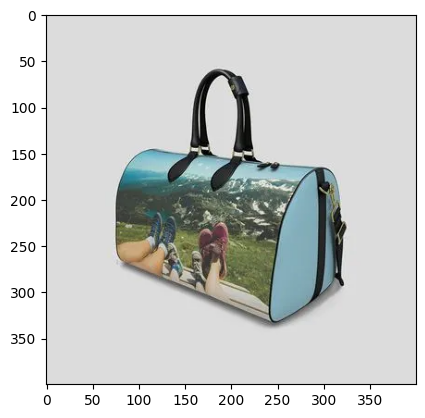

In [126]:
raw_image = Image.open('product_image.png').convert("RGB")
plt.imshow(raw_image)
plt.show()

In [127]:


input_boxes = [[[50, 50, 350,350]]]  # Single point click, 4 dimensions (image_dim, object_dim, point_per_object_dim, coordinates)

inputs = processor(images=raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])[0]
# The model outputs multiple mask predictions ranked by quality score
print(f"Generated {masks.shape[1]} masks with shape {masks.shape}")

Generated 3 masks with shape torch.Size([1, 3, 400, 400])


In [128]:
mask = masks[0,outputs.iou_scores.argmax().item()].cpu().numpy()
mask = 1-mask.astype(np.uint8)

# raw_image is already loaded as RGB
rgb = np.array(raw_image)
# Ensure mask is uint8 in range 0–255
alpha = (mask * 255).astype(np.uint8)
# Stack RGB + alpha
rgba = np.dstack([rgb, alpha])
# Convert to PIL image
rgba_image = Image.fromarray(rgba, mode="RGBA")


## Inpainting Pipeline

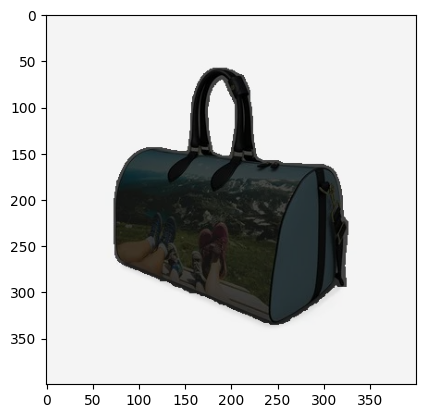

In [144]:
from scipy.ndimage import gaussian_filter,grey_dilation

ref_image = rgba_image.convert('RGB')

mask_filtered = grey_dilation(mask, size=(5,5))
mask_filtered = gaussian_filter(mask_filtered, sigma=1)
mask_pil=Image.fromarray((mask_filtered  * 255).astype(np.uint8))

# plot the mask and inv mask
plt.imshow(ref_image)
plt.imshow(mask_pil,cmap='grey',alpha=0.7)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

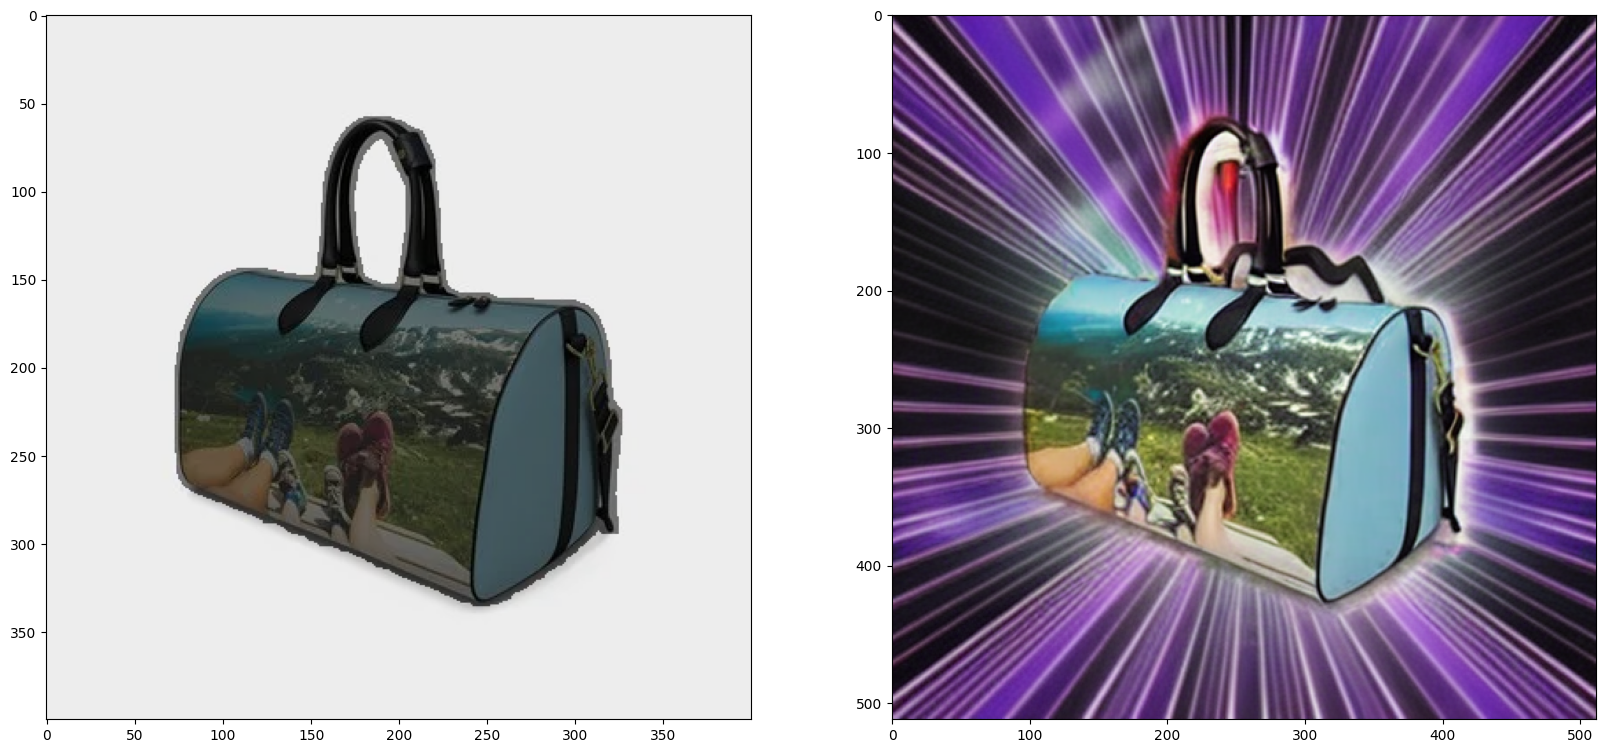

In [154]:
gen_image = inpaint_pipe(prompt="Dark purple background with dynamic speed lines and bright light rays emanating from behind",
                         negative_prompt="blurry, low resolution",
                            image=ref_image.resize((768,768)), 
                            mask_image=mask_pil.resize((768,768)),
                            # strength=1.0, 
                            guidance_scale=7.5, 
                            num_inference_steps=30,
                            ).images[0]

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.imshow(mask_pil,cmap='grey',alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()